In [1]:
## April 24th, 2020
## purpose: what can we glean from COVID articles? Can we use NLP to see how has sentiment changed over time?
## By: Amanda Hutter

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os 
import datetime
from datetime import timedelta

import glob
import json


pd.set_option('display.max_columns', None)

In [3]:
#os.getcwd()
rootfolder = "/Users/amandahutter/Documents/PythonCode/KaggleFiles/COVID/CORD-19-research-challenge"
os.chdir(rootfolder)
os.listdir()

['CORD19-Analysis.ipynb',
 '.DS_Store',
 'custom_license',
 'metadata.readme',
 'json_schema.txt',
 'noncomm_use_subset',
 'cord_19_embeddings_4_17',
 'metadata.csv',
 '.ipynb_checkpoints',
 'biorxiv_medrxiv',
 'COVID.DATA.LIC.AGMT.pdf',
 'comm_use_subset']

## Read in Metadata file

In [4]:
date_cols = ['publish_time']
meta = pd.read_csv("metadata.csv", engine = 'python', 
                   parse_dates = date_cols, 
                   dtype = {'pubmed_id': str, 'doi': str, 'Microsoft Academic Paper ID':str}
                  )

In [5]:
meta.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [6]:
meta.isna().sum()

cord_uid                           0
sha                            13374
source_x                           0
title                            158
doi                             3340
pmcid                           8746
pubmed_id                      14340
license                            0
abstract                        9230
publish_time                       8
authors                         2279
journal                         5242
Microsoft Academic Paper ID    51434
WHO #Covidence                 50630
has_pdf_parse                      0
has_pmc_xml_parse                  0
full_text_file                  8604
url                              302
dtype: int64

In [7]:
meta.shape

(52398, 18)

In [8]:
meta.dtypes

cord_uid                               object
sha                                    object
source_x                               object
title                                  object
doi                                    object
pmcid                                  object
pubmed_id                              object
license                                object
abstract                               object
publish_time                   datetime64[ns]
authors                                object
journal                                object
Microsoft Academic Paper ID            object
WHO #Covidence                         object
has_pdf_parse                            bool
has_pmc_xml_parse                        bool
full_text_file                         object
url                                    object
dtype: object

In [9]:
## Drop the rows which are missing variables of interest
meta.dropna(subset=['publish_time', 'abstract','title'], inplace = True)

meta.shape

(43012, 18)

In [10]:
# What do the titles say?
meta.iloc[0]['title']

'Airborne rhinovirus detection and effect of ultraviolet irradiation on detection by a semi-nested RT-PCR assay'

In [11]:
meta.iloc[1]['title']

'Discovering human history from stomach bacteria'

In [12]:
meta.iloc[2]['title']

'A new recruit for the army of the men of death'

In [13]:
# What do the abstracts say?
meta.iloc[0]['abstract']

'BACKGROUND: Rhinovirus, the most common cause of upper respiratory tract infections, has been implicated in asthma exacerbations and possibly asthma deaths. Although the method of transmission of rhinoviruses is disputed, several studies have demonstrated that aerosol transmission is a likely method of transmission among adults. As a first step in studies of possible airborne rhinovirus transmission, we developed methods to detect aerosolized rhinovirus by extending existing technology for detecting infectious agents in nasal specimens. METHODS: We aerosolized rhinovirus in a small aerosol chamber. Experiments were conducted with decreasing concentrations of rhinovirus. To determine the effect of UV irradiation on detection of rhinoviral aerosols, we also conducted experiments in which we exposed aerosols to a UV dose of 684 mJ/m(2). Aerosols were collected on Teflon filters and rhinovirus recovered in Qiagen AVL buffer using the Qiagen QIAamp Viral RNA Kit (Qiagen Corp., Valencia, Ca

In [14]:
# What time period are we working with?
print("Oldest article:", min(meta['publish_time']))
print("Newest article:", max(meta['publish_time']))

## Why is there an article from the future?
meta['year'] = meta['publish_time'].dt.year

Oldest article: 1955-10-31 00:00:00
Newest article: 2020-12-31 00:00:00


In [15]:
## Are there more articles in recent months and years, as this pandemic grew nearer?

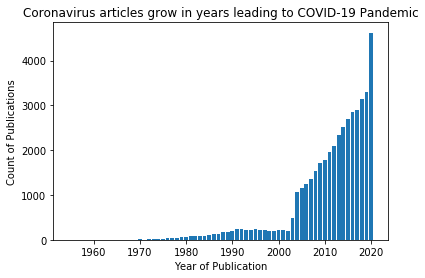

In [16]:
count_by_year = meta[['year','cord_uid']].groupby(['year']).count()
count_by_year = count_by_year.reset_index()
count_by_year['year'] = count_by_year['year'].astype(int)
count_by_year = count_by_year.rename(columns = {'cord_uid':'count'})

count_by_year.head()

x = count_by_year['year']
y = count_by_year['count']

plt.xlabel("Year of Publication")
plt.ylabel("Count of Publications")

plt.title("Coronavirus articles grow in years leading to COVID-19 Pandemic")

plt.bar(x, y)

plt.show()

In [17]:
# Which journal is the most popular for publishing papers on COVID? 

count_by_journal = meta[['journal','cord_uid']].groupby('journal').count().reset_index()

count_by_journal = count_by_journal.rename(columns = {'cord_uid':'count'})

count_by_journal.sort_values(by = 'count', ascending = False).head(15)


,journal,count
3443,Journal of Virology,1722
4231,PLoS One,1567
5451,Virology,816
1709,Emerg Infect Dis,572
5466,Viruses,563
464,Arch Virol,495
4827,Sci Rep,492
5459,Virus Research,437
5422,Veterinary Microbiology,408
3442,Journal of Virological Methods,363


## Read in CORD19 Embeddings File 

In [18]:
#embed =  pd.read_csv("cord_19_embeddings_4_17/cord_19_embeddings_4_17.csv", engine = 'python')

In [19]:
#embed.head()

In [20]:
#embed.shape

In [21]:
#embed.isna().sum()

In [22]:
## This is the same number of rows as the Metadata set

In [23]:
meta.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,2003
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,2003
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,2003
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,2003
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,2003


## Weekly Bar Chart of Publications

In [24]:
def prior_sun(dt):
    return dt - timedelta(days =((dt.isoweekday() + 0) % 7))

meta['weekStart'] = meta['publish_time'].apply(prior_sun)

In [25]:
#meta['weekStart'] = meta['publish_time'].apply(prior_sun)

In [26]:
start_date = "2019-5-1"
end_date = "2020-4-30"

after_start_date = meta["weekStart"] >= start_date
before_end_date = meta["weekStart"] <= end_date
between_two_dates = after_start_date & before_end_date
recent_meta = meta.loc[between_two_dates]

/Users/amandahutter/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


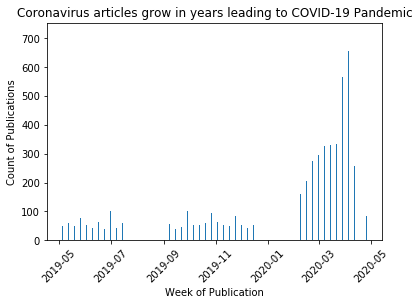

In [27]:
count_by_week = recent_meta[['weekStart','cord_uid']].groupby(['weekStart']).count()
count_by_week = count_by_week.reset_index()
count_by_week['weekStart'] = count_by_week['weekStart']
count_by_week = count_by_week.rename(columns = {'cord_uid':'count'})

count_by_week.head()

x = count_by_week['weekStart']
y = count_by_week['count']

plt.xticks(rotation=45)
plt.xlabel("Week of Publication")
plt.ylabel("Count of Publications")
plt.title("Coronavirus articles grow in years leading to COVID-19 Pandemic")
plt.bar(x, y)
plt.show()

## Add NLP stuff to abstracts

In [28]:
import re 

# Import NLTK to assist with removing the non important words 
import nltk 

from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amandahutter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
#recent_meta['abstract']

#recent_meta.iloc[0][8]

recent_meta.iloc[0]['abstract']

'In the United States, outbreaks of avian influenza H5 and H7 virus infections in poultry have raised concern about the risk for infections in humans. We reviewed the data collected during 2014–2017 and found no human infections among 4,555 exposed responders who were wearing protection.'

In [30]:
# Remove the non important words 
abstract = re.sub(pattern = '[^a-zA-Z]', repl = ' ', string = recent_meta.iloc[0]['abstract']) 
print(abstract)

# Lowercase  
abstract = abstract.lower()
print(abstract)

# Split string
abstract = abstract.split()
print(abstract)

# Make Porter stemmer to stem our words, to remove suffix & prefix
ps = PorterStemmer()

# Keep the words in the list that are not in the Stopwords list 
abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))]
print(abstract)

# Convert back to string 
abstract = ' '.join(abstract)
print(abstract)

In the United States  outbreaks of avian influenza H  and H  virus infections in poultry have raised concern about the risk for infections in humans  We reviewed the data collected during           and found no human infections among       exposed responders who were wearing protection 
in the united states  outbreaks of avian influenza h  and h  virus infections in poultry have raised concern about the risk for infections in humans  we reviewed the data collected during           and found no human infections among       exposed responders who were wearing protection 
['in', 'the', 'united', 'states', 'outbreaks', 'of', 'avian', 'influenza', 'h', 'and', 'h', 'virus', 'infections', 'in', 'poultry', 'have', 'raised', 'concern', 'about', 'the', 'risk', 'for', 'infections', 'in', 'humans', 'we', 'reviewed', 'the', 'data', 'collected', 'during', 'and', 'found', 'no', 'human', 'infections', 'among', 'exposed', 'responders', 'who', 'were', 'wearing', 'protection']
['unit', 'state', 'outbreak

### Create Corpus of Abstracts

In [31]:
# Loop through all reviews in your dataset and do above process 

# corpus refers to the cleaned reviews
abstract_corpus= []

for i in range (0, len(recent_meta)):
    abstract = re.sub(pattern = '[^a-zA-Z]', repl = ' ', string = recent_meta.iloc[i]['abstract'])
    abstract = abstract.lower()
    abstract = abstract.split()
    ps = PorterStemmer()
    abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))]
    abstract = ' '.join(abstract)
    abstract_corpus.append(abstract)
print(abstract_corpus[1:15])

['strateg multilater dialogu relat biosecur risk southeast asia establish includ particip singapor malaysia indonesia thailand philippin unit state dialogu conduct nonministeri level enabl particip engag without constraint oper offici capac particip reflect mechan detect mitig respond biosecur risk highlight biosecur issu nation leadership particip also identifi factor improv region global biosecur includ improv engag collabor across relev ministri agenc sustain fund biosecur program enhanc inform share communic diseas increas engag intern biosecur forum', 'experienc qualifi personnel certifi work high level biocontain laboratori contribut safe oper facil china began train program laboratori user establish first biosafeti level laboratori wuhan nation biosafeti laboratori level chines academi scienc provid overview content train program serv refer develop nation norm high contain laboratori train', 'evalu genet variat middl east respiratori syndrom coronaviru mer cov import south korea

## (II) NLTK-VADER: Add libraries for Unsupervised Sentiment Analysis 

### https://www.nltk.org/api/nltk.sentiment.html
### https://github.com/cjhutto/vaderSentiment

If you use the VADER sentiment analysis tools, please cite:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [32]:
# https://medium.com/@Intellica.AI/vader-ibm-watson-or-textblob-which-is-better-for-unsupervised-sentiment-analysis-db4143a39445

#import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/amandahutter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    for key in sorted(ss):
        print('{0}: {1}, '.format(key, ss[key]), end='')
        print()
        
    #for key, val in ss.items():
    #    print(key)
    #    print(val)

### What is the Compound value? It uses the valence to measure overall sentiment. Typically, >0.05 is Positive, <-.05 is Negative, else it is Neutral

### https://github.com/cjhutto/vaderSentiment#about-the-scoring

In [34]:
print(abstract_corpus[0])
get_vader_score(abstract_corpus[0])

unit state outbreak avian influenza h h viru infect poultri rais concern risk infect human review data collect found human infect among expos respond wear protect
compound: 0.128, 
neg: 0.079, 
neu: 0.824, 
pos: 0.097, 


In [35]:
get_vader_score(abstract_corpus[1])

compound: 0.1027, 
neg: 0.054, 
neu: 0.887, 
pos: 0.059, 


In [36]:
get_vader_score(abstract_corpus[-1])

compound: 0.9001, 
neg: 0.0, 
neu: 0.817, 
pos: 0.183, 


## (II.ii) TextBlob for Sentiment Analysis on Unstructured data

In [37]:
from textblob import TextBlob

# Get the polarity score using below function
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    return polarity

In [38]:
print(abstract_corpus[0])
get_textBlob_score(abstract_corpus[0])

unit state outbreak avian influenza h h viru infect poultri rais concern risk infect human review data collect found human infect among expos respond wear protect


0.0

In [39]:
print(abstract_corpus[1])
get_textBlob_score(abstract_corpus[1])

strateg multilater dialogu relat biosecur risk southeast asia establish includ particip singapor malaysia indonesia thailand philippin unit state dialogu conduct nonministeri level enabl particip engag without constraint oper offici capac particip reflect mechan detect mitig respond biosecur risk highlight biosecur issu nation leadership particip also identifi factor improv region global biosecur includ improv engag collabor across relev ministri agenc sustain fund biosecur program enhanc inform share communic diseas increas engag intern biosecur forum


0.0

In [40]:
print(abstract_corpus[-1])
get_textBlob_score(abstract_corpus[-1])

decemb china diagnos first patient novel coronaviru diseas covid follow develop epidem huge impact china whole world patient lung occupi lesion whole process diagnosi treatment carri usual due epidem thorac surgeon time surgic intervent care consid thorac surgeon china work togeth develop proper procedur diagnosi treatment special situat continu updat recommend base epidem chang understand covid offer preliminari suggest base knowledg refer discuss


-0.05678571428571429

In [41]:
print(abstract_corpus[-10])
get_textBlob_score(abstract_corpus[-10])

summari background respoc studi demonstr syndrom molecular point care test poct respiratori virus associ earli discontinu unnecessari antibiot compar routin clinic care subgroup analysi suggest chang occur predominantli patient exacerb airway diseas use molecular poct respiratori virus becom widespread lack evid inform choic multiplex syndrom panel versu poct influenza materi method evalu patient respoc studi exacerb asthma copd treat antibiot durat antibiot proport earli discontinu compar patient test posit neg virus poct control patient test posit virus poct compar accord viru type result patient exacerb airway diseas receiv antibiot poct group control group poct group patient test posit virus test posit virus earli discontinu antibiot versu test neg control p posit virus poct posit influenza rhinoviru virus proport earli discontinu antibiot differ viru type p conclus data suggest syndrom molecular poct respiratori virus favour poct influenza alon adult exacerb airway diseas


0.1

Consider whether Textblob or NLTK Vader should be used to understand sentiment of publication headlines. NLTK Vader provides more granularity 

## (III) NLTK Vader POC

### Return to Vader  - Toy Example with Phrases

In [42]:
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    dict_list.append(ss)
    

In [43]:
list_of_phrases = ["I have the measles and the mumps", "We are the champions", "I do not like green eggs"]

dict_list = []

for i in range(0, len(list_of_phrases)):
    print(list_of_phrases[i])
    get_vader_score(list_of_phrases[i])

neg_list = []
neu_list = []
pos_list = []
compound_list = []

for i in range(0, len(dict_list)):
    neg_list.append(dict_list[i]["neg"])
    neu_list.append(dict_list[i]["neu"])
    pos_list.append(dict_list[i]["pos"])
    compound_list.append(dict_list[i]["compound"])

print(neg_list)
print(neu_list)
print(pos_list)
print(compound_list)

I have the measles and the mumps
We are the champions
I do not like green eggs
[0.0, 0.0, 0.345]
[1.0, 0.469, 0.655]
[0.0, 0.531, 0.0]
[0.0, 0.5267, -0.2755]


In [44]:
vader_df = pd.DataFrame( list(zip(list_of_phrases, neg_list, neu_list, pos_list, compound_list)), columns = ["Phrases",'Negative','Neutral','Positive','Compound'])

In [45]:
vader_df

,Phrases,Negative,Neutral,Positive,Compound
0,I have the measles and the mumps,0.000,1.000,0.000,0.0000
1,We are the champions,0.000,0.469,0.531,0.5267
2,I do not like green eggs,0.345,0.655,0.000,-0.2755


In [46]:
dict_list

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.469, 'pos': 0.531, 'compound': 0.5267},
 {'neg': 0.345, 'neu': 0.655, 'pos': 0.0, 'compound': -0.2755}]

### (III.i) Vader - Example with Abstract Corpus

In [47]:
#abstract_corpus = corpus

In [48]:
dict_list.clear

dict_list = []

for i in range(0, len(abstract_corpus)):
    get_vader_score(abstract_corpus[i])

In [49]:
neg_list = []
neu_list = []
pos_list = []
compound_list = []
for i in range(0, len(dict_list)):
    neg_list.append(dict_list[i]["neg"])
    neu_list.append(dict_list[i]["neu"])
    pos_list.append(dict_list[i]["pos"])
    compound_list.append(dict_list[i]["compound"])

In [50]:
vader_df = pd.DataFrame( list(zip(abstract_corpus, neg_list, neu_list, pos_list, compound_list)), columns = ["Abstracts",'Negative','Neutral','Positive','Compound'])

In [51]:
vader_df.head()

,Abstracts,Negative,Neutral,Positive,Compound
0,unit state outbreak avian influenza h h viru i...,0.079,0.824,0.097,0.1280
1,strateg multilater dialogu relat biosecur risk...,0.054,0.887,0.059,0.1027
2,experienc qualifi personnel certifi work high ...,0.000,0.939,0.061,0.4404
3,evalu genet variat middl east respiratori synd...,0.076,0.924,0.000,-0.1027
4,camel contact recogn risk factor middl east re...,0.062,0.901,0.037,-0.3612


In [52]:
vader_df.describe()

,Negative,Neutral,Positive,Compound
count,6550.000000,6550.000000,6550.000000,6550.000000
mean,0.052713,0.876506,0.070627,0.154298
std,0.054566,0.075972,0.054361,0.634103
min,0.000000,0.000000,0.000000,-0.998500
25%,0.015000,0.837000,0.033000,-0.401900
50%,0.039000,0.889000,0.060000,0.296000
75%,0.075000,0.929000,0.096000,0.743000
max,0.481000,1.000000,0.615000,0.997900


In [53]:
vader_df.index

RangeIndex(start=0, stop=6550, step=1)

In [54]:
#recent_meta.head()

In [55]:
print(recent_meta.index)

recent_meta = recent_meta.reset_index()

print(recent_meta.index)

Int64Index([10708, 10709, 10710, 10711, 10712, 10769, 10777, 10779, 10782,
            10783,
            ...
            52272, 52278, 52296, 52320, 52324, 52331, 52359, 52382, 52383,
            52392],
           dtype='int64', length=6550)
RangeIndex(start=0, stop=6550, step=1)


In [56]:
recent_vader = pd.concat([recent_meta, vader_df], axis = 1)

In [57]:
print(recent_vader.shape)
recent_vader.head()

(6550, 26)


,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year,weekStart,Abstracts,Negative,Neutral,Positive,Compound
0,10708,11780xv7,cd12db30cf8d039ec120a0766259d9311d9a466d,PMC,Estimating Risk to Responders Exposed to Avian...,10.3201/eid2505.181253,PMC6478193,30741630,no-cc,"In the United States, outbreaks of avian influ...",2019-05-16,"Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,unit state outbreak avian influenza h h viru i...,0.079,0.824,0.097,0.1280
1,10709,xudxudrc,8762e3de42e45d93aebb675328dd466f8be23cf2,PMC,Southeast Asia Strategic Multilateral Dialogue...,10.3201/eid2505.181659,PMC6478199,31002062,no-cc,A strategic multilateral dialogue related to b...,2019-05-16,"Cicero, Anita; Meyer, Diane; Shearer, Matthew ...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,strateg multilater dialogu relat biosecur risk...,0.054,0.887,0.059,0.1027
2,10710,h26rcae2,5ccde00be19e522ea42e8198124df31de00f6afb,PMC,Biosafety Level 4 Laboratory User Training Pro...,10.3201/eid2505.180220,PMC6478205,31002302,no-cc,"Experienced, qualified personnel certified to ...",2019-05-16,"Xia, Han; Huang, Yi; Ma, Haixia; Liu, Bobo; Xi...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,experienc qualifi personnel certifi work high ...,0.000,0.939,0.061,0.4404
3,10711,6mrd9axh,983e4e747ad0691e47cb54ed407a014f66f96380,PMC,Genetic Characterization of Middle East Respir...,10.3201/eid2505.181534,PMC6478226,30753126,no-cc,We evaluated genetic variation in Middle East ...,2019-05-16,"Chung, Yoon-Seok; Kim, Jeong Min; Man Kim, Heu...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,evalu genet variat middl east respiratori synd...,0.076,0.924,0.000,-0.1027
4,10712,g42n51n9,44a3cf460f8ce1edf8df41d96242735398773acd,PMC,Risk Factors for MERS-CoV Seropositivity among...,10.3201/eid2505.181728,PMC6478233,31002068,no-cc,Camel contact is a recognized risk factor for ...,2019-05-16,"Khudhair, Ahmed; Killerby, Marie E.; Al Mulla,...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,camel contact recogn risk factor middl east re...,0.062,0.901,0.037,-0.3612


### Compound Sentiment weekly has a slightly decreasing trend entering 2020

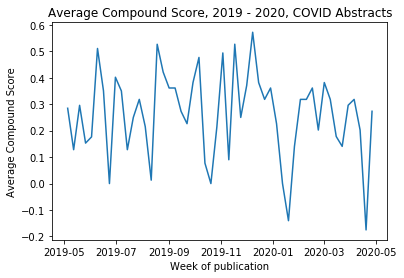

In [58]:
compound_by_week = recent_vader[['weekStart','Compound']].groupby('weekStart').median()
compound_by_week = compound_by_week.reset_index()

x = compound_by_week['weekStart']
y = compound_by_week['Compound']

plt.ylabel("Average Compound Score")
plt.xlabel("Week of publication")
plt.title("Average Compound Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Abstracts with Negative sentiment are Increasing in 2020

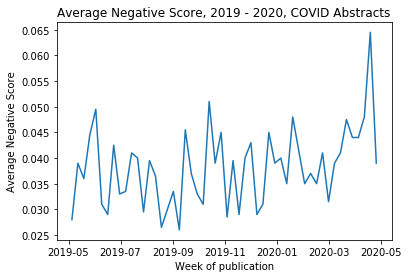

In [59]:
negative_by_week = recent_vader[['weekStart','Negative']].groupby('weekStart').median()
negative_by_week = negative_by_week.reset_index()

x = negative_by_week['weekStart']
y = negative_by_week['Negative']

plt.ylabel("Average Negative Score")
plt.xlabel("Week of publication")
plt.title("Average Negative Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Positive Sentiment is increasing with Abstracts Published in 2020 

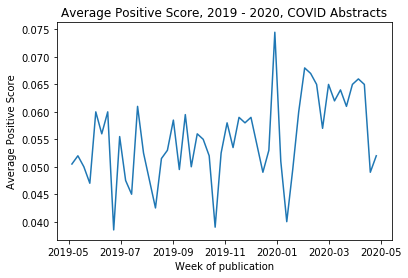

In [60]:
positive_by_week = recent_vader[['weekStart','Positive']].groupby('weekStart').median()
positive_by_week = positive_by_week.reset_index()

x = positive_by_week['weekStart']
y = positive_by_week['Positive']

plt.ylabel("Average Positive Score")
plt.xlabel("Week of publication")
plt.title("Average Positive Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Neutral Sentiment Abstracts have decreased through 2020

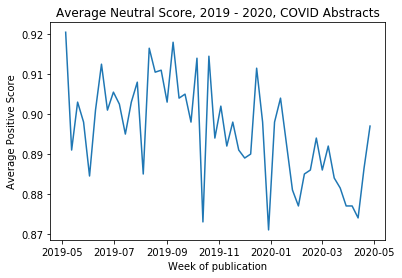

In [61]:
neutral_by_week = recent_vader[['weekStart','Neutral']].groupby('weekStart').median()
neutral_by_week = neutral_by_week.reset_index()

x = neutral_by_week['weekStart']
y = neutral_by_week['Neutral']

plt.ylabel("Average Positive Score")
plt.xlabel("Week of publication")
plt.title("Average Neutral Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Analyze the Positive/Negative scores using Vader on Abstracts with given thresholds for Compound Score

In [62]:
recent_vader['Sentiment'] = 'Neutral' # Default
recent_vader.loc[recent_vader['Compound'] <= -.05, 'Sentiment'] = 'Negative' 
recent_vader.loc[recent_vader['Compound'] >= 0.05, 'Sentiment'] = 'Positive'

recent_vader['POS'] = 0
recent_vader.loc[recent_vader['Sentiment'] == "Positive", "POS"] = 1

recent_vader['NEG'] = 0
recent_vader.loc[recent_vader['Sentiment'] == "Negative", "NEG"] = 1

recent_vader['NEU'] = 0
recent_vader.loc[recent_vader['Sentiment'] == "Neutral", "NEU"] = 1

recent_vader.head()

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year,weekStart,Abstracts,Negative,Neutral,Positive,Compound,Sentiment,POS,NEG,NEU
0,10708,11780xv7,cd12db30cf8d039ec120a0766259d9311d9a466d,PMC,Estimating Risk to Responders Exposed to Avian...,10.3201/eid2505.181253,PMC6478193,30741630,no-cc,"In the United States, outbreaks of avian influ...",2019-05-16,"Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,unit state outbreak avian influenza h h viru i...,0.079,0.824,0.097,0.1280,Positive,1,0,0
1,10709,xudxudrc,8762e3de42e45d93aebb675328dd466f8be23cf2,PMC,Southeast Asia Strategic Multilateral Dialogue...,10.3201/eid2505.181659,PMC6478199,31002062,no-cc,A strategic multilateral dialogue related to b...,2019-05-16,"Cicero, Anita; Meyer, Diane; Shearer, Matthew ...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,strateg multilater dialogu relat biosecur risk...,0.054,0.887,0.059,0.1027,Positive,1,0,0
2,10710,h26rcae2,5ccde00be19e522ea42e8198124df31de00f6afb,PMC,Biosafety Level 4 Laboratory User Training Pro...,10.3201/eid2505.180220,PMC6478205,31002302,no-cc,"Experienced, qualified personnel certified to ...",2019-05-16,"Xia, Han; Huang, Yi; Ma, Haixia; Liu, Bobo; Xi...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,experienc qualifi personnel certifi work high ...,0.000,0.939,0.061,0.4404,Positive,1,0,0
3,10711,6mrd9axh,983e4e747ad0691e47cb54ed407a014f66f96380,PMC,Genetic Characterization of Middle East Respir...,10.3201/eid2505.181534,PMC6478226,30753126,no-cc,We evaluated genetic variation in Middle East ...,2019-05-16,"Chung, Yoon-Seok; Kim, Jeong Min; Man Kim, Heu...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,evalu genet variat middl east respiratori synd...,0.076,0.924,0.000,-0.1027,Negative,0,1,0
4,10712,g42n51n9,44a3cf460f8ce1edf8df41d96242735398773acd,PMC,Risk Factors for MERS-CoV Seropositivity among...,10.3201/eid2505.181728,PMC6478233,31002068,no-cc,Camel contact is a recognized risk factor for ...,2019-05-16,"Khudhair, Ahmed; Killerby, Marie E.; Al Mulla,...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,camel contact recogn risk factor middl east re...,0.062,0.901,0.037,-0.3612,Negative,0,1,0


## Show Volume of Positive, Negative, and Neutral Abstracts over time 

In [63]:
# Overall, abstracts are Positive or Negative, fewer Neutral using compound score
recent_vader[['weekStart', 'Sentiment']].groupby(['Sentiment']).count()

,weekStart
Sentiment,
Negative,2372
Neutral,370
Positive,3808


In [64]:
## TODO: create groupby and plot here
sentiment_by_week = recent_vader[['weekStart', 'Sentiment','cord_uid']].groupby(['weekStart','Sentiment']).count()
sentiment_by_week = sentiment_by_week.reset_index()
sentiment_by_week.rename(columns = {'cord_uid': 'Count'}, inplace = True)

sentiment_by_week.head(9)

,weekStart,Sentiment,Count
0,2019-05-05,Negative,16
1,2019-05-05,Neutral,4
2,2019-05-05,Positive,30
3,2019-05-12,Negative,25
4,2019-05-12,Neutral,1
5,2019-05-12,Positive,33
6,2019-05-19,Negative,19
7,2019-05-19,Neutral,2
8,2019-05-19,Positive,29


### Weekly Sentiments of Abstracts with Vader Score 

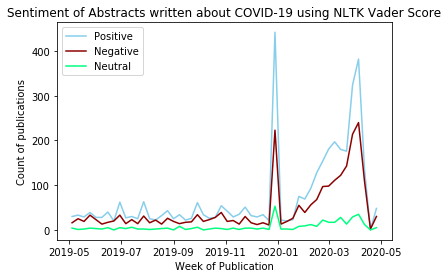

In [65]:
weekly_sentiment_abstracts = recent_vader[['weekStart', 'POS','NEU','NEG']].groupby('weekStart').sum().reset_index()

plt.plot('weekStart', 'POS', data = weekly_sentiment_abstracts, color = 'skyblue', label = "Positive")
plt.plot('weekStart', 'NEG', data = weekly_sentiment_abstracts, color = 'darkred', label = "Negative")
plt.plot('weekStart', 'NEU', data = weekly_sentiment_abstracts, color = 'springgreen', label = "Neutral")

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.title("Sentiment of Abstracts written about COVID-19 using NLTK Vader Score")
plt.legend()

plt.show()

## (III.ii) Vader with Title Corpus

In [66]:
# Loop through all reviews in your dataset and do above process 

# corpus refers to the cleaned reviews
title_corpus= []

for i in range (0, len(recent_meta)):
    abstract = re.sub(pattern = '[^a-zA-Z]', repl = ' ', string = recent_meta.iloc[i]['title'])
    abstract = abstract.lower()
    abstract = abstract.split()
    ps = PorterStemmer()
    abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))]
    abstract = ' '.join(abstract)
    title_corpus.append(abstract)
print(title_corpus[1:15])

['southeast asia strateg multilater dialogu biosecur', 'biosafeti level laboratori user train program china', 'genet character middl east respiratori syndrom coronaviru south korea', 'risk factor mer cov seroposit among anim market slaughterhous worker abu dhabi unit arab emir', 'percept postoutbreak manag manag healthcar worker middl east respiratori syndrom outbreak tertiari care hospit qualit studi', 'tini iceland prepar ebola global world', 'factor influenc diagnosi treatment latent tuberculosi among contact congreg set korea', 'three asymptomat anim infect model hemorrhag fever renal syndrom caus hantavirus', 'molecular character two novel reovirus isol muscovi duckl guangdong china', 'simultan detect differenti canin parvoviru felin parvoviru high resolut melt analysi', 'associ blood eosinophil percent bacteri infect acut exacerb chronic obstruct pulmonari diseas', 'impact host genet biolog respons modifi respiratori tract infect', 'bovin herpesviru counteract immun respons immun

In [67]:
dict_list.clear

dict_list = []

for i in range(0, len(title_corpus)):
    get_vader_score(title_corpus[i])

In [68]:
neg_list = []
neu_list = []
pos_list = []
compound_list = []
for i in range(0, len(dict_list)):
    neg_list.append(dict_list[i]["neg"])
    neu_list.append(dict_list[i]["neu"])
    pos_list.append(dict_list[i]["pos"])
    compound_list.append(dict_list[i]["compound"])

In [69]:
title_vader = pd.DataFrame(list(zip(title_corpus, neg_list, neu_list, pos_list, compound_list)),
                        columns = ["Titles",'Negative','Neutral','Positive','Compound'])

In [70]:
title_vader.head()

,Titles,Negative,Neutral,Positive,Compound
0,estim risk respond expos avian influenza h h v...,0.189,0.811,0.0,-0.2732
1,southeast asia strateg multilater dialogu bios...,0.000,1.000,0.0,0.0000
2,biosafeti level laboratori user train program ...,0.000,1.000,0.0,0.0000
3,genet character middl east respiratori syndrom...,0.000,1.000,0.0,0.0000
4,risk factor mer cov seroposit among anim marke...,0.130,0.870,0.0,-0.2732


In [71]:
title_vader.describe()

,Negative,Neutral,Positive,Compound
count,6550.000000,6550.000000,6550.000000,6550.000000
mean,0.041869,0.899005,0.058363,0.024221
std,0.102040,0.149003,0.111136,0.242906
min,0.000000,0.000000,0.000000,-0.941300
25%,0.000000,0.803000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.090750,0.000000
max,0.778000,1.000000,0.808000,0.844200


### Merge datasets for Vader + Title

In [72]:
recent_title = pd.concat([recent_meta, title_vader], axis = 1)

In [73]:
recent_title.head()

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year,weekStart,Titles,Negative,Neutral,Positive,Compound
0,10708,11780xv7,cd12db30cf8d039ec120a0766259d9311d9a466d,PMC,Estimating Risk to Responders Exposed to Avian...,10.3201/eid2505.181253,PMC6478193,30741630,no-cc,"In the United States, outbreaks of avian influ...",2019-05-16,"Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,estim risk respond expos avian influenza h h v...,0.189,0.811,0.0,-0.2732
1,10709,xudxudrc,8762e3de42e45d93aebb675328dd466f8be23cf2,PMC,Southeast Asia Strategic Multilateral Dialogue...,10.3201/eid2505.181659,PMC6478199,31002062,no-cc,A strategic multilateral dialogue related to b...,2019-05-16,"Cicero, Anita; Meyer, Diane; Shearer, Matthew ...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,southeast asia strateg multilater dialogu bios...,0.000,1.000,0.0,0.0000
2,10710,h26rcae2,5ccde00be19e522ea42e8198124df31de00f6afb,PMC,Biosafety Level 4 Laboratory User Training Pro...,10.3201/eid2505.180220,PMC6478205,31002302,no-cc,"Experienced, qualified personnel certified to ...",2019-05-16,"Xia, Han; Huang, Yi; Ma, Haixia; Liu, Bobo; Xi...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,biosafeti level laboratori user train program ...,0.000,1.000,0.0,0.0000
3,10711,6mrd9axh,983e4e747ad0691e47cb54ed407a014f66f96380,PMC,Genetic Characterization of Middle East Respir...,10.3201/eid2505.181534,PMC6478226,30753126,no-cc,We evaluated genetic variation in Middle East ...,2019-05-16,"Chung, Yoon-Seok; Kim, Jeong Min; Man Kim, Heu...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,genet character middl east respiratori syndrom...,0.000,1.000,0.0,0.0000
4,10712,g42n51n9,44a3cf460f8ce1edf8df41d96242735398773acd,PMC,Risk Factors for MERS-CoV Seropositivity among...,10.3201/eid2505.181728,PMC6478233,31002068,no-cc,Camel contact is a recognized risk factor for ...,2019-05-16,"Khudhair, Ahmed; Killerby, Marie E.; Al Mulla,...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,risk factor mer cov seroposit among anim marke...,0.130,0.870,0.0,-0.2732


### Compound Titles

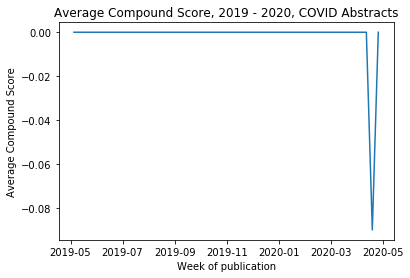

In [74]:
compound_by_week = recent_title[['weekStart','Compound']].groupby('weekStart').median()
compound_by_week = compound_by_week.reset_index()

x = compound_by_week['weekStart']
y = compound_by_week['Compound']

plt.ylabel("Average Compound Score")
plt.xlabel("Week of publication")
plt.title("Average Compound Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Negative Titles

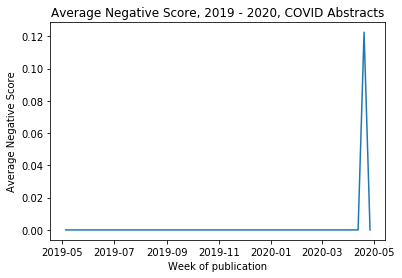

In [75]:
negative_by_week = recent_title[['weekStart','Negative']].groupby('weekStart').median()
negative_by_week = negative_by_week.reset_index()

x = negative_by_week['weekStart']
y = negative_by_week['Negative']

plt.ylabel("Average Negative Score")
plt.xlabel("Week of publication")
plt.title("Average Negative Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Positive Titles

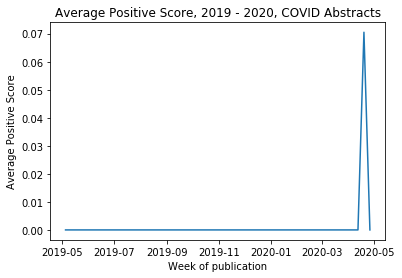

In [76]:
positive_by_week = recent_title[['weekStart','Positive']].groupby('weekStart').median()
positive_by_week = positive_by_week.reset_index()

x = positive_by_week['weekStart']
y = positive_by_week['Positive']

plt.ylabel("Average Positive Score")
plt.xlabel("Week of publication")
plt.title("Average Positive Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Neutral Titles still fairly common, but with some non-neutral spikes in 2020

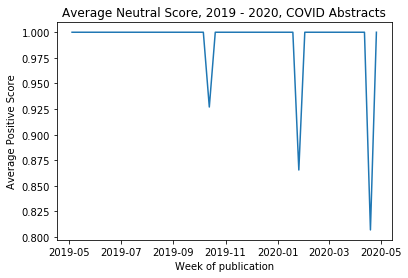

In [77]:
neutral_by_week = recent_title[['weekStart','Neutral']].groupby('weekStart').median()
neutral_by_week = neutral_by_week.reset_index()

x = neutral_by_week['weekStart']
y = neutral_by_week['Neutral']

plt.ylabel("Average Positive Score")
plt.xlabel("Week of publication")
plt.title("Average Neutral Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Use Vader Compound Score to determine if Title is mostly Positive, Negative, or Neutral 

In [78]:
recent_title['Sentiment'] = 'Neutral' # Default
recent_title.loc[recent_title['Compound'] <= -.05, 'Sentiment'] = 'Negative' 
recent_title.loc[recent_title['Compound'] >= 0.05, 'Sentiment'] = 'Positive'

recent_title['POS'] = 0
recent_title.loc[recent_title['Sentiment'] == "Positive", "POS"] = 1

recent_title['NEG'] = 0
recent_title.loc[recent_title['Sentiment'] == "Negative", "NEG"] = 1

recent_title['NEU'] = 0
recent_title.loc[recent_title['Sentiment'] == "Neutral", "NEU"] = 1

recent_title.head()

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year,weekStart,Titles,Negative,Neutral,Positive,Compound,Sentiment,POS,NEG,NEU
0,10708,11780xv7,cd12db30cf8d039ec120a0766259d9311d9a466d,PMC,Estimating Risk to Responders Exposed to Avian...,10.3201/eid2505.181253,PMC6478193,30741630,no-cc,"In the United States, outbreaks of avian influ...",2019-05-16,"Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,estim risk respond expos avian influenza h h v...,0.189,0.811,0.0,-0.2732,Negative,0,1,0
1,10709,xudxudrc,8762e3de42e45d93aebb675328dd466f8be23cf2,PMC,Southeast Asia Strategic Multilateral Dialogue...,10.3201/eid2505.181659,PMC6478199,31002062,no-cc,A strategic multilateral dialogue related to b...,2019-05-16,"Cicero, Anita; Meyer, Diane; Shearer, Matthew ...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,southeast asia strateg multilater dialogu bios...,0.000,1.000,0.0,0.0000,Neutral,0,0,1
2,10710,h26rcae2,5ccde00be19e522ea42e8198124df31de00f6afb,PMC,Biosafety Level 4 Laboratory User Training Pro...,10.3201/eid2505.180220,PMC6478205,31002302,no-cc,"Experienced, qualified personnel certified to ...",2019-05-16,"Xia, Han; Huang, Yi; Ma, Haixia; Liu, Bobo; Xi...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,biosafeti level laboratori user train program ...,0.000,1.000,0.0,0.0000,Neutral,0,0,1
3,10711,6mrd9axh,983e4e747ad0691e47cb54ed407a014f66f96380,PMC,Genetic Characterization of Middle East Respir...,10.3201/eid2505.181534,PMC6478226,30753126,no-cc,We evaluated genetic variation in Middle East ...,2019-05-16,"Chung, Yoon-Seok; Kim, Jeong Min; Man Kim, Heu...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,genet character middl east respiratori syndrom...,0.000,1.000,0.0,0.0000,Neutral,0,0,1
4,10712,g42n51n9,44a3cf460f8ce1edf8df41d96242735398773acd,PMC,Risk Factors for MERS-CoV Seropositivity among...,10.3201/eid2505.181728,PMC6478233,31002068,no-cc,Camel contact is a recognized risk factor for ...,2019-05-16,"Khudhair, Ahmed; Killerby, Marie E.; Al Mulla,...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,risk factor mer cov seroposit among anim marke...,0.130,0.870,0.0,-0.2732,Negative,0,1,0


### Show volume of Titles that are Positive, Neutral, or Negative 

In [79]:
recent_title[['weekStart', 'Sentiment']].groupby(['Sentiment']).count().reset_index()

,Sentiment,weekStart
0,Negative,1011
1,Neutral,4116
2,Positive,1423


Titles are far more likely to be classified as Neutral than their respective abstracts 

### Show weekly Title sentiment using NLTK Vader

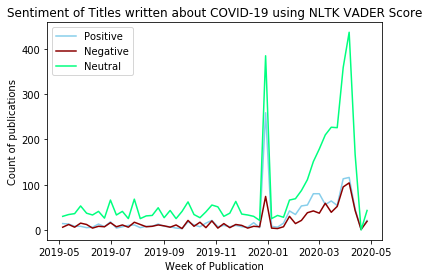

In [80]:
weekly_sentiment_titles = recent_title[['weekStart', 'POS','NEU','NEG']].groupby('weekStart').sum().reset_index()

plt.plot('weekStart', 'POS', data = weekly_sentiment_titles, color = 'skyblue', label = "Positive")
plt.plot('weekStart', 'NEG', data = weekly_sentiment_titles, color = 'darkred', label = "Negative")
plt.plot('weekStart', 'NEU', data = weekly_sentiment_titles, color = 'springgreen', label = 'Neutral')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment of Titles written about COVID-19 using NLTK VADER Score")
plt.show()

### Compare the sentiment of Titles and Abstracts, by week 

In [81]:
# Merge together these dataframes with weekly counts of sentiment 
sentiments_abs_tits_vader = pd.merge(weekly_sentiment_abstracts, weekly_sentiment_titles, how = 'left', on = 'weekStart')

sentiments_abs_tits_vader.rename(columns = 
                           {'POS_x':'POS_abstracts','POS_y':'POS_titles',
                           'NEU_x':'NEU_abstracts', 'NEU_y':'NEU_titles',
                           'NEG_x': 'NEG_abstracts', 'NEG_y': 'NEG_titles'},
                           inplace=True)
sentiments_abs_tits_vader.head()

,weekStart,POS_abstracts,NEU_abstracts,NEG_abstracts,POS_titles,NEU_titles,NEG_titles
0,2019-05-05,30,4,16,14,30,6
1,2019-05-12,33,1,25,13,34,12
2,2019-05-19,29,2,19,8,36,6
3,2019-05-26,39,4,33,8,53,15
4,2019-06-02,28,3,23,5,37,12


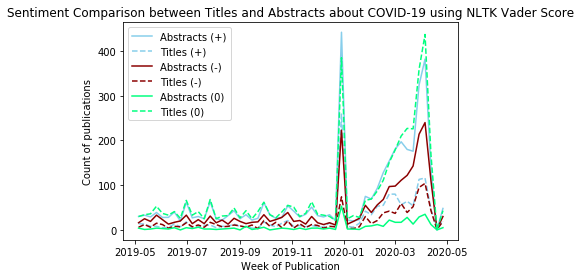

In [82]:
plt.plot('weekStart', 'POS_abstracts', data = sentiments_abs_tits_vader, color = 'skyblue', label = "Abstracts (+)")
plt.plot('weekStart', 'POS_titles', data = sentiments_abs_tits_vader, color = 'skyblue', linestyle = 'dashed', label = 'Titles (+)')
plt.plot('weekStart', 'NEG_abstracts', data = sentiments_abs_tits_vader, color = 'darkred', label = "Abstracts (-)")
plt.plot('weekStart', 'NEG_titles', data = sentiments_abs_tits_vader, color = 'darkred', linestyle = 'dashed', label = "Titles (-)")
plt.plot('weekStart', 'NEU_abstracts', data = sentiments_abs_tits_vader, color = 'springgreen', label = "Abstracts (0)")
plt.plot('weekStart', 'NEU_titles', data = sentiments_abs_tits_vader, color = 'springgreen', linestyle = 'dashed', label = "Titles (0)")

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using NLTK Vader Score")
plt.show()

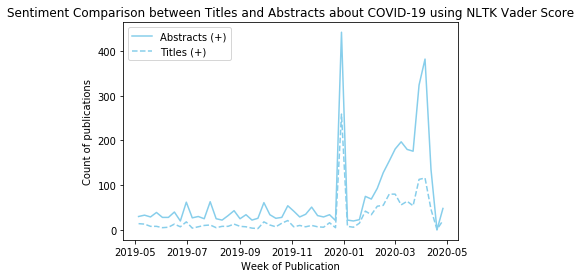

In [83]:
plt.plot('weekStart', 'POS_abstracts', data = sentiments_abs_tits_vader, color = 'skyblue', label = "Abstracts (+)")
plt.plot('weekStart', 'POS_titles', data = sentiments_abs_tits_vader, color = 'skyblue', linestyle = 'dashed', label = 'Titles (+)')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using NLTK Vader Score")
plt.show()

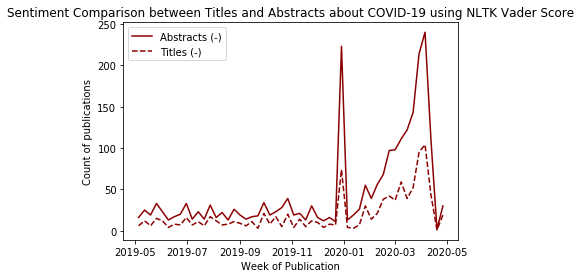

In [84]:
plt.plot('weekStart', 'NEG_abstracts', data = sentiments_abs_tits_vader, color = 'darkred', label = "Abstracts (-)")
plt.plot('weekStart', 'NEG_titles', data = sentiments_abs_tits_vader, color = 'darkred', linestyle = 'dashed', label = "Titles (-)")

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using NLTK Vader Score")
plt.show()

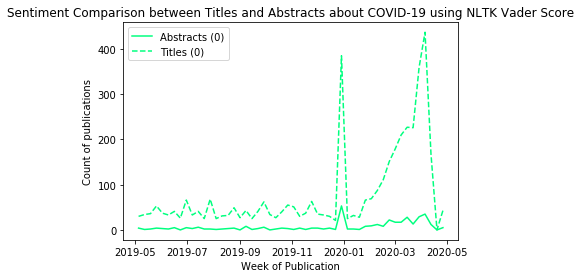

In [85]:
plt.plot('weekStart', 'NEU_abstracts', data = sentiments_abs_tits_vader, color = 'springgreen', label = "Abstracts (0)")
plt.plot('weekStart', 'NEU_titles', data = sentiments_abs_tits_vader, color = 'springgreen', linestyle = 'dashed', label = "Titles (0)")

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using NLTK Vader Score")
plt.show()

## (IV) Using Textblob

### (IV) Textblob on Abstracts Corpus

In [86]:
abstract_corpus[:3]

['unit state outbreak avian influenza h h viru infect poultri rais concern risk infect human review data collect found human infect among expos respond wear protect',
 'strateg multilater dialogu relat biosecur risk southeast asia establish includ particip singapor malaysia indonesia thailand philippin unit state dialogu conduct nonministeri level enabl particip engag without constraint oper offici capac particip reflect mechan detect mitig respond biosecur risk highlight biosecur issu nation leadership particip also identifi factor improv region global biosecur includ improv engag collabor across relev ministri agenc sustain fund biosecur program enhanc inform share communic diseas increas engag intern biosecur forum',
 'experienc qualifi personnel certifi work high level biocontain laboratori contribut safe oper facil china began train program laboratori user establish first biosafeti level laboratori wuhan nation biosafeti laboratori level chines academi scienc provid overview conte

In [87]:
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    subjectivity = TextBlob(sent).sentiment.subjectivity
    return polarity, subjectivity

In [88]:
get_textBlob_score(abstract_corpus[10])

(-0.015238095238095235, 0.41761904761904756)

In [89]:
textBlob_polar = []
textBlob_subj = []

for i in range(0, len(abstract_corpus)):
    polarity, subjectivity = get_textBlob_score(abstract_corpus[i])
    textBlob_polar.append(polarity)
    textBlob_subj.append(subjectivity)

In [90]:
print("Min score:", min(textBlob_polar))
print("Max score:", max(textBlob_polar))
print("Length:",len(textBlob_polar))

print("Min score:", min(textBlob_subj))
print("Max score:", max(textBlob_subj))
print("Length:",len(textBlob_subj))

Min score: -0.8
Max score: 1.0
Length: 6550
Min score: 0.0
Max score: 1.0
Length: 6550


### Distribution from Textblob

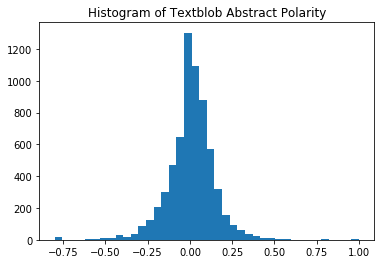

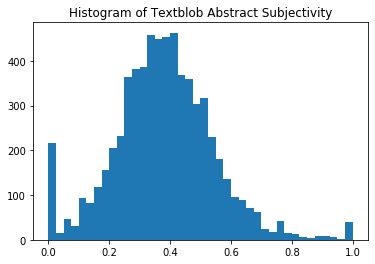

In [91]:
data = textBlob_polar
num_bins = 40 # <- number of bins for the histogram
plt.hist(data, num_bins)
plt.title("Histogram of Textblob Abstract Polarity")
plt.show()

data = textBlob_subj
num_bins = 40 # <- number of bins for the histogram
plt.hist(data, num_bins)
plt.title("Histogram of Textblob Abstract Subjectivity")
plt.show()

### Zip lists together - Abstracts Textblob

In [92]:
abstract_textblob = pd.DataFrame(list(zip(abstract_corpus, textBlob_polar, textBlob_subj)),
                        columns = ["Abstracts",'Polarity','Subjectivity'])

abstract_textblob

,Abstracts,Polarity,Subjectivity
0,unit state outbreak avian influenza h h viru i...,0.000000,0.100000
1,strateg multilater dialogu relat biosecur risk...,0.000000,0.000000
2,experienc qualifi personnel certifi work high ...,0.267500,0.478333
3,evalu genet variat middl east respiratori synd...,0.000000,0.400000
4,camel contact recogn risk factor middl east re...,0.041970,0.492500
...,...,...,...
6545,abstract background differenti acut chest synd...,0.070833,0.273810
6546,inc decemb outbreak novel coronaviru sar cov i...,0.131250,0.181250
6547,abstract avian infecti bronchiti ib acut highl...,-0.069821,0.574286
6548,model enabl contin better alloc scarc resourc ...,0.065000,0.510000


In [93]:
# Determine Overall Sentiment
abstract_textblob['Sentiment'] = "Neutral"
abstract_textblob.loc[abstract_textblob['Polarity'] < 0, 'Sentiment'] = 'Negative' 
abstract_textblob.loc[abstract_textblob['Polarity'] > 0, 'Sentiment'] = 'Positive'

# Determine POS, NEG, NEU binary columns
abstract_textblob['POS'] = 0
abstract_textblob.loc[abstract_textblob['Sentiment'] == "Positive", "POS"] = 1

abstract_textblob['NEG'] = 0
abstract_textblob.loc[abstract_textblob['Sentiment'] == "Negative", "NEG"] = 1

abstract_textblob['NEU'] = 0
abstract_textblob.loc[abstract_textblob['Sentiment'] == "Neutral", "NEU"] = 1

abstract_textblob.head()

,Abstracts,Polarity,Subjectivity,Sentiment,POS,NEG,NEU
0,unit state outbreak avian influenza h h viru i...,0.00000,0.100000,Neutral,0,0,1
1,strateg multilater dialogu relat biosecur risk...,0.00000,0.000000,Neutral,0,0,1
2,experienc qualifi personnel certifi work high ...,0.26750,0.478333,Positive,1,0,0
3,evalu genet variat middl east respiratori synd...,0.00000,0.400000,Neutral,0,0,1
4,camel contact recogn risk factor middl east re...,0.04197,0.492500,Positive,1,0,0


### Merge Datasets for Abstracts + Textblob

In [94]:
recent_textblob_abs = pd.concat([recent_meta, abstract_textblob], axis = 1)

recent_textblob_abs.head()

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year,weekStart,Abstracts,Polarity,Subjectivity,Sentiment,POS,NEG,NEU
0,10708,11780xv7,cd12db30cf8d039ec120a0766259d9311d9a466d,PMC,Estimating Risk to Responders Exposed to Avian...,10.3201/eid2505.181253,PMC6478193,30741630,no-cc,"In the United States, outbreaks of avian influ...",2019-05-16,"Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,unit state outbreak avian influenza h h viru i...,0.00000,0.100000,Neutral,0,0,1
1,10709,xudxudrc,8762e3de42e45d93aebb675328dd466f8be23cf2,PMC,Southeast Asia Strategic Multilateral Dialogue...,10.3201/eid2505.181659,PMC6478199,31002062,no-cc,A strategic multilateral dialogue related to b...,2019-05-16,"Cicero, Anita; Meyer, Diane; Shearer, Matthew ...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,strateg multilater dialogu relat biosecur risk...,0.00000,0.000000,Neutral,0,0,1
2,10710,h26rcae2,5ccde00be19e522ea42e8198124df31de00f6afb,PMC,Biosafety Level 4 Laboratory User Training Pro...,10.3201/eid2505.180220,PMC6478205,31002302,no-cc,"Experienced, qualified personnel certified to ...",2019-05-16,"Xia, Han; Huang, Yi; Ma, Haixia; Liu, Bobo; Xi...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,experienc qualifi personnel certifi work high ...,0.26750,0.478333,Positive,1,0,0
3,10711,6mrd9axh,983e4e747ad0691e47cb54ed407a014f66f96380,PMC,Genetic Characterization of Middle East Respir...,10.3201/eid2505.181534,PMC6478226,30753126,no-cc,We evaluated genetic variation in Middle East ...,2019-05-16,"Chung, Yoon-Seok; Kim, Jeong Min; Man Kim, Heu...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,evalu genet variat middl east respiratori synd...,0.00000,0.400000,Neutral,0,0,1
4,10712,g42n51n9,44a3cf460f8ce1edf8df41d96242735398773acd,PMC,Risk Factors for MERS-CoV Seropositivity among...,10.3201/eid2505.181728,PMC6478233,31002068,no-cc,Camel contact is a recognized risk factor for ...,2019-05-16,"Khudhair, Ahmed; Killerby, Marie E.; Al Mulla,...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,camel contact recogn risk factor middl east re...,0.04197,0.492500,Positive,1,0,0


### Group by week charts for Polarity & Subjectivity

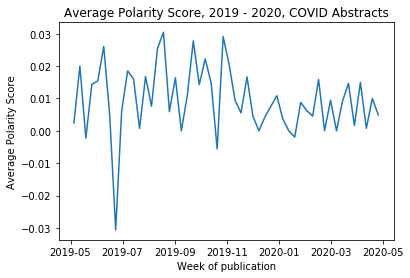

In [95]:
polarity_by_week = recent_textblob_abs[['weekStart','Polarity']].groupby('weekStart').median()
polarity_by_week = polarity_by_week.reset_index()

x = polarity_by_week['weekStart']
y = polarity_by_week['Polarity']

plt.ylabel("Average Polarity Score")
plt.xlabel("Week of publication")
plt.title("Average Polarity Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

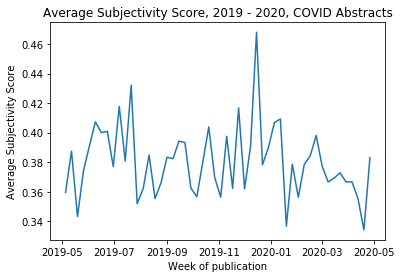

In [96]:
subjectivity_by_week = recent_textblob_abs[['weekStart','Subjectivity']].groupby('weekStart').median()
subjectivity_by_week = subjectivity_by_week.reset_index()

x = subjectivity_by_week['weekStart']
y = subjectivity_by_week['Subjectivity']

plt.ylabel("Average Subjectivity Score")
plt.xlabel("Week of publication")
plt.title("Average Subjectivity Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Textblob Sentiment Grouping over the year

In [97]:
recent_textblob_abs[['weekStart', 'Sentiment']].groupby(['Sentiment']).count().reset_index()

,Sentiment,weekStart
0,Negative,2657
1,Neutral,436
2,Positive,3457


### Textblob Weekly Sentiment 

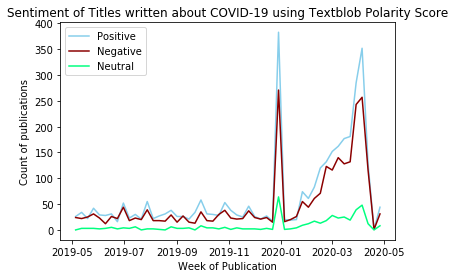

In [98]:
weekly_sentiment_abstracts = recent_textblob_abs[['weekStart', 'POS','NEU','NEG']].groupby('weekStart').sum().reset_index()

plt.plot('weekStart', 'POS', data = weekly_sentiment_abstracts, color = 'skyblue', label = "Positive")
plt.plot('weekStart', 'NEG', data = weekly_sentiment_abstracts, color = 'darkred', label = "Negative")
plt.plot('weekStart', 'NEU', data = weekly_sentiment_abstracts, color = 'springgreen', label = 'Neutral')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment of Titles written about COVID-19 using Textblob Polarity Score")
plt.show()

In [99]:
weekly_sentiment_titles.head()

,weekStart,POS,NEU,NEG
0,2019-05-05,14,30,6
1,2019-05-12,13,34,12
2,2019-05-19,8,36,6
3,2019-05-26,8,53,15
4,2019-06-02,5,37,12


## (IV.ii) Textblob on Titles Corpus

In [100]:
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    subjectivity = TextBlob(sent).sentiment.subjectivity
    return polarity, subjectivity

In [101]:
textBlob_polar = []
textBlob_subj = []

for i in range(0, len(title_corpus)):
    polarity, subjectivity = get_textBlob_score(title_corpus[i])
    textBlob_polar.append(polarity)
    textBlob_subj.append(subjectivity)

In [102]:
print("Min score:", min(textBlob_polar))
print("Max score:", max(textBlob_polar))
print("Length:",len(textBlob_polar))

print("Min score:", min(textBlob_subj))
print("Max score:", max(textBlob_subj))
print("Length:",len(textBlob_subj))

Min score: -0.8
Max score: 1.0
Length: 6550
Min score: 0.0
Max score: 1.0
Length: 6550


### Data from Textblob - Titles Histogram 

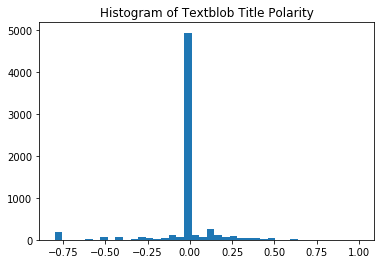

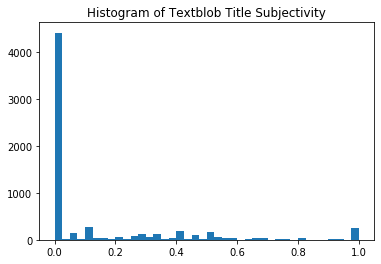

In [103]:
data = textBlob_polar
num_bins = 40 # <- number of bins for the histogram
plt.hist(data, num_bins)
plt.title("Histogram of Textblob Title Polarity")
plt.show()

data = textBlob_subj
num_bins = 40 # <- number of bins for the histogram
plt.hist(data, num_bins)
plt.title("Histogram of Textblob Title Subjectivity")
plt.show()

Histograms of Titles by Textblob confirm that Titles are much less subjective and much more neutral than Abstracts

In [104]:
title_textblob = pd.DataFrame(list(zip(title_corpus, textBlob_polar, textBlob_subj)),
                        columns = ["Titles",'Polarity','Subjectivity'])

title_textblob

,Titles,Polarity,Subjectivity
0,estim risk respond expos avian influenza h h v...,0.00,0.00
1,southeast asia strateg multilater dialogu bios...,0.00,0.00
2,biosafeti level laboratori user train program ...,0.00,0.00
3,genet character middl east respiratori syndrom...,0.00,0.00
4,risk factor mer cov seroposit among anim marke...,0.00,0.00
...,...,...,...
6545,molecular test respiratori pathogen sickl cell...,0.05,0.15
6546,posit result sar cov sputum cure patient covid,0.00,0.00
6547,effect tlr agonist infect bronchiti viru repli...,-0.60,0.95
6548,loom threat covid infect africa act collect fast,0.20,0.60


In [105]:
# Determine Overall Sentiment
title_textblob['Sentiment'] = "Neutral"
title_textblob.loc[title_textblob['Polarity'] < 0, 'Sentiment'] = 'Negative' 
title_textblob.loc[title_textblob['Polarity'] > 0, 'Sentiment'] = 'Positive'

# Determine POS, NEG, NEU binary columns
title_textblob['POS'] = 0
title_textblob.loc[title_textblob['Sentiment'] == "Positive", "POS"] = 1

title_textblob['NEG'] = 0
title_textblob.loc[title_textblob['Sentiment'] == "Negative", "NEG"] = 1

title_textblob['NEU'] = 0
title_textblob.loc[title_textblob['Sentiment'] == "Neutral", "NEU"] = 1

title_textblob.head()

,Titles,Polarity,Subjectivity,Sentiment,POS,NEG,NEU
0,estim risk respond expos avian influenza h h v...,0.0,0.0,Neutral,0,0,1
1,southeast asia strateg multilater dialogu bios...,0.0,0.0,Neutral,0,0,1
2,biosafeti level laboratori user train program ...,0.0,0.0,Neutral,0,0,1
3,genet character middl east respiratori syndrom...,0.0,0.0,Neutral,0,0,1
4,risk factor mer cov seroposit among anim marke...,0.0,0.0,Neutral,0,0,1


### Merge Datasets 

In [106]:
recent_textblob_tits = pd.concat([recent_meta, title_textblob], axis = 1)

recent_textblob_tits.head(3)

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year,weekStart,Titles,Polarity,Subjectivity,Sentiment,POS,NEG,NEU
0,10708,11780xv7,cd12db30cf8d039ec120a0766259d9311d9a466d,PMC,Estimating Risk to Responders Exposed to Avian...,10.3201/eid2505.181253,PMC6478193,30741630,no-cc,"In the United States, outbreaks of avian influ...",2019-05-16,"Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,estim risk respond expos avian influenza h h v...,0.0,0.0,Neutral,0,0,1
1,10709,xudxudrc,8762e3de42e45d93aebb675328dd466f8be23cf2,PMC,Southeast Asia Strategic Multilateral Dialogue...,10.3201/eid2505.181659,PMC6478199,31002062,no-cc,A strategic multilateral dialogue related to b...,2019-05-16,"Cicero, Anita; Meyer, Diane; Shearer, Matthew ...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,southeast asia strateg multilater dialogu bios...,0.0,0.0,Neutral,0,0,1
2,10710,h26rcae2,5ccde00be19e522ea42e8198124df31de00f6afb,PMC,Biosafety Level 4 Laboratory User Training Pro...,10.3201/eid2505.180220,PMC6478205,31002302,no-cc,"Experienced, qualified personnel certified to ...",2019-05-16,"Xia, Han; Huang, Yi; Ma, Haixia; Liu, Bobo; Xi...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,biosafeti level laboratori user train program ...,0.0,0.0,Neutral,0,0,1


### Group by week for Polarity and Subjectivity

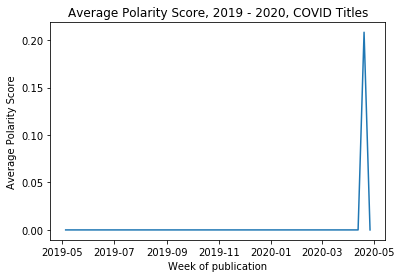

In [107]:
polarity_by_week = recent_textblob_tits[['weekStart','Polarity']].groupby('weekStart').median()
polarity_by_week = polarity_by_week.reset_index()

x = polarity_by_week['weekStart']
y = polarity_by_week['Polarity']

plt.ylabel("Average Polarity Score")
plt.xlabel("Week of publication")
plt.title("Average Polarity Score, 2019 - 2020, COVID Titles")
plt.plot(x, y)
plt.show()

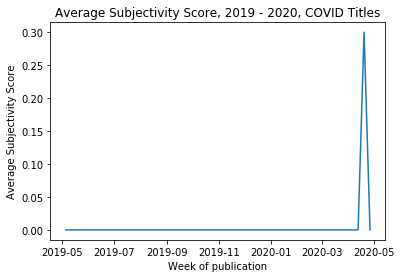

In [108]:
subjectivity_by_week = recent_textblob_tits[['weekStart','Subjectivity']].groupby('weekStart').median()
subjectivity_by_week = subjectivity_by_week.reset_index()

x = subjectivity_by_week['weekStart']
y = subjectivity_by_week['Subjectivity']

plt.ylabel("Average Subjectivity Score")
plt.xlabel("Week of publication")
plt.title("Average Subjectivity Score, 2019 - 2020, COVID Titles")
plt.plot(x, y)
plt.show()

### Sentiment over the year - Titles with Texblob

In [109]:
recent_textblob_tits[['weekStart', 'Sentiment']].groupby(['Sentiment']).count().reset_index()

,Sentiment,weekStart
0,Negative,781
1,Neutral,4894
2,Positive,875


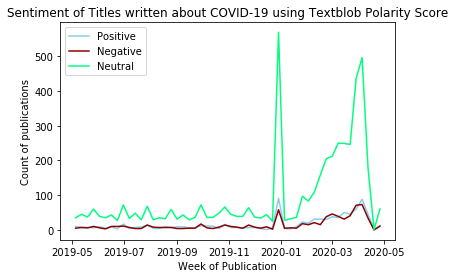

In [110]:
weekly_sentiment_titles = recent_textblob_tits[['weekStart', 'POS','NEU','NEG']].groupby('weekStart').sum().reset_index()

plt.plot('weekStart', 'POS', data = weekly_sentiment_titles, color = 'skyblue', label = "Positive")
plt.plot('weekStart', 'NEG', data = weekly_sentiment_titles, color = 'darkred', label = "Negative")
plt.plot('weekStart', 'NEU', data = weekly_sentiment_titles, color = 'springgreen', label = 'Neutral')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment of Titles written about COVID-19 using Textblob Polarity Score")
plt.show()

### Compare the Sentiments of Abstracts & Titles, week by week with Textblob

In [111]:
# Merge together these dataframes with weekly counts of sentiment 
sentiments_abs_tits_text = pd.merge(weekly_sentiment_abstracts, weekly_sentiment_titles, how = 'left', on = 'weekStart')

sentiments_abs_tits_text.rename(columns = 
                           {'POS_x':'POS_abstracts','POS_y':'POS_titles',
                           'NEU_x':'NEU_abstracts', 'NEU_y':'NEU_titles',
                           'NEG_x': 'NEG_abstracts', 'NEG_y': 'NEG_titles'},
                           inplace=True)
sentiments_abs_tits_text.head()

,weekStart,POS_abstracts,NEU_abstracts,NEG_abstracts,POS_titles,NEU_titles,NEG_titles
0,2019-05-05,26,0,24,10,35,5
1,2019-05-12,34,3,22,7,45,7
2,2019-05-19,22,3,25,7,37,6
3,2019-05-26,42,3,31,6,60,10
4,2019-06-02,29,2,23,9,39,6


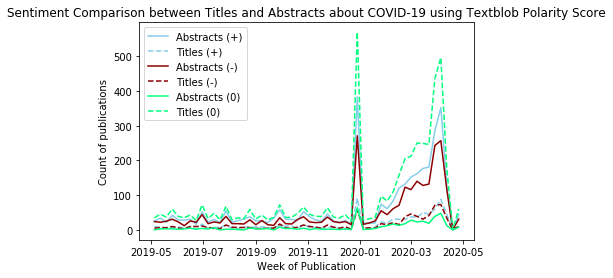

In [112]:
plt.plot('weekStart', 'POS_abstracts', data = sentiments_abs_tits_text, color = 'skyblue', label = "Abstracts (+)")
plt.plot('weekStart', 'POS_titles', data = sentiments_abs_tits_text, color = 'skyblue', linestyle = 'dashed', label = 'Titles (+)')
plt.plot('weekStart', 'NEG_abstracts', data = sentiments_abs_tits_text, color = 'darkred', label = "Abstracts (-)")
plt.plot('weekStart', 'NEG_titles', data = sentiments_abs_tits_text, color = 'darkred', linestyle = 'dashed', label = "Titles (-)")
plt.plot('weekStart', 'NEU_abstracts', data = sentiments_abs_tits_text, color = 'springgreen', label = "Abstracts (0)")
plt.plot('weekStart', 'NEU_titles', data = sentiments_abs_tits_text, color = 'springgreen', linestyle = 'dashed', label = "Titles (0)")

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using Textblob Polarity Score")
plt.show()

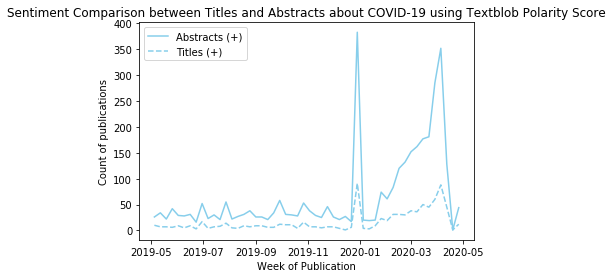

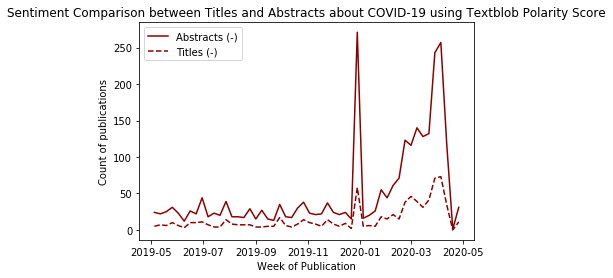

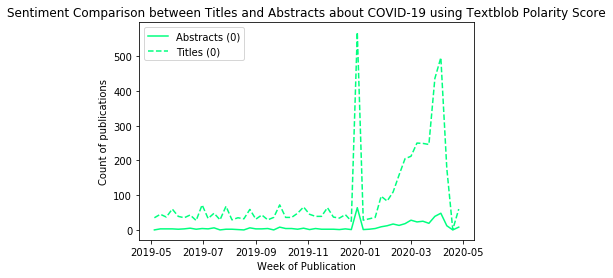

In [113]:
plt.plot('weekStart', 'POS_abstracts', data = sentiments_abs_tits_text, color = 'skyblue', label = "Abstracts (+)")
plt.plot('weekStart', 'POS_titles', data = sentiments_abs_tits_text, color = 'skyblue', linestyle = 'dashed', label = 'Titles (+)')
plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using Textblob Polarity Score")
plt.show()

plt.plot('weekStart', 'NEG_abstracts', data = sentiments_abs_tits_text, color = 'darkred', label = "Abstracts (-)")
plt.plot('weekStart', 'NEG_titles', data = sentiments_abs_tits_text, color = 'darkred', linestyle = 'dashed', label = "Titles (-)")
plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using Textblob Polarity Score")
plt.show()


plt.plot('weekStart', 'NEU_abstracts', data = sentiments_abs_tits_text, color = 'springgreen', label = "Abstracts (0)")
plt.plot('weekStart', 'NEU_titles', data = sentiments_abs_tits_text, color = 'springgreen', linestyle = 'dashed', label = "Titles (0)")
plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using Textblob Polarity Score")
plt.show()

Similar to NLTK Vader, we see that Textblob Polarity score shows that Titles are far more neutral than Abstracts. 

In [114]:
#sentiments_abs_tits_vader.head()

In [115]:
#sentiments_abs_tits_text.head()

In [116]:
sentiments_vader_text =  pd.merge(sentiments_abs_tits_vader, sentiments_abs_tits_text, how = 'left', on = 'weekStart')


sentiments_vader_text.rename(columns = 
                           {'POS_abstracts_x':'POS_abstracts_vader','POS_abstracts_y':'POS_abstracts_text',
                            'POS_titles_x':'POS_titles_vader','POS_titles_y':'POS_titles_text',
                            'NEU_abstracts_x':'NEU_abstracts_vader','NEU_abstracts_y':'NEU_abstracts_text',
                            'NEU_titles_x':'NEU_titles_vader','NEU_titles_y':'NEU_titles_text',
                            'NEG_abstracts_x':'NEG_abstracts_vader','NEG_abstracts_y':'NEG_abstracts_text',
                            'NEG_titles_x':'NEG_titles_vader','NEG_titles_y':'NEG_titles_text',
                           },
                           inplace=True)
sentiments_vader_text.head()

,weekStart,POS_abstracts_vader,NEU_abstracts_vader,NEG_abstracts_vader,POS_titles_vader,NEU_titles_vader,NEG_titles_vader,POS_abstracts_text,NEU_abstracts_text,NEG_abstracts_text,POS_titles_text,NEU_titles_text,NEG_titles_text
0,2019-05-05,30,4,16,14,30,6,26,0,24,10,35,5
1,2019-05-12,33,1,25,13,34,12,34,3,22,7,45,7
2,2019-05-19,29,2,19,8,36,6,22,3,25,7,37,6
3,2019-05-26,39,4,33,8,53,15,42,3,31,6,60,10
4,2019-06-02,28,3,23,5,37,12,29,2,23,9,39,6


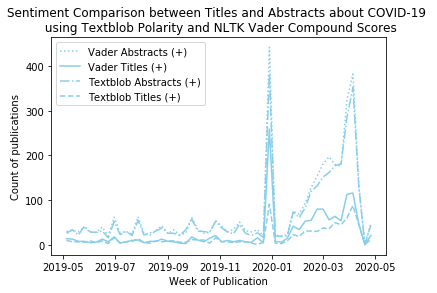

In [117]:
plt.plot('weekStart', 'POS_abstracts_vader', data = sentiments_vader_text, color = 'skyblue', linestyle = 'dotted', label = "Vader Abstracts (+)")
plt.plot('weekStart', 'POS_titles_vader', data = sentiments_vader_text, color = 'skyblue', linestyle = 'solid', label = 'Vader Titles (+)')
plt.plot('weekStart', 'POS_abstracts_text', data = sentiments_vader_text, color = 'skyblue', linestyle = 'dashdot',label = "Textblob Abstracts (+)")
plt.plot('weekStart', 'POS_titles_text', data = sentiments_vader_text, color = 'skyblue', linestyle = 'dashed', label = 'Textblob Titles (+)')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 \n using Textblob Polarity and NLTK Vader Compound Scores")
plt.show()

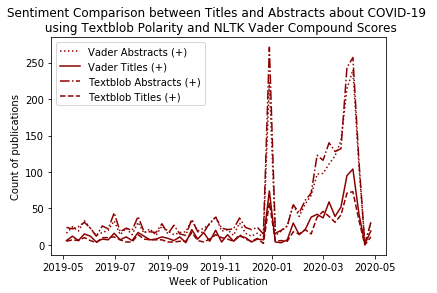

In [118]:
plt.plot('weekStart', 'NEG_abstracts_vader', data = sentiments_vader_text, color = 'darkred', linestyle = 'dotted', label = "Vader Abstracts (+)")
plt.plot('weekStart', 'NEG_titles_vader', data = sentiments_vader_text, color = 'darkred', linestyle = 'solid', label = 'Vader Titles (+)')
plt.plot('weekStart', 'NEG_abstracts_text', data = sentiments_vader_text, color = 'darkred', linestyle = 'dashdot',label = "Textblob Abstracts (+)")
plt.plot('weekStart', 'NEG_titles_text', data = sentiments_vader_text, color = 'darkred', linestyle = 'dashed', label = 'Textblob Titles (+)')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 \n using Textblob Polarity and NLTK Vader Compound Scores")
plt.show()

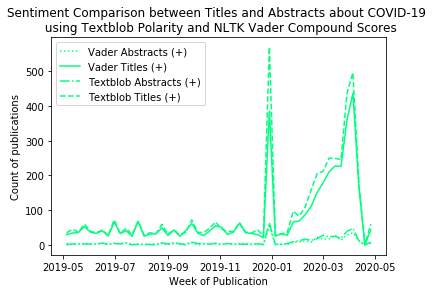

In [119]:
plt.plot('weekStart', 'NEU_abstracts_vader', data = sentiments_vader_text, color = 'springgreen', linestyle = 'dotted', label = "Vader Abstracts (+)")
plt.plot('weekStart', 'NEU_titles_vader', data = sentiments_vader_text, color = 'springgreen', linestyle = 'solid', label = 'Vader Titles (+)')
plt.plot('weekStart', 'NEU_abstracts_text', data = sentiments_vader_text, color = 'springgreen', linestyle = 'dashdot',label = "Textblob Abstracts (+)")
plt.plot('weekStart', 'NEU_titles_text', data = sentiments_vader_text, color = 'springgreen', linestyle = 'dashed', label = 'Textblob Titles (+)')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 \n using Textblob Polarity and NLTK Vader Compound Scores")
plt.show()

In [120]:
recent_meta.head()

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year,weekStart
0,10708,11780xv7,cd12db30cf8d039ec120a0766259d9311d9a466d,PMC,Estimating Risk to Responders Exposed to Avian...,10.3201/eid2505.181253,PMC6478193,30741630,no-cc,"In the United States, outbreaks of avian influ...",2019-05-16,"Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12
1,10709,xudxudrc,8762e3de42e45d93aebb675328dd466f8be23cf2,PMC,Southeast Asia Strategic Multilateral Dialogue...,10.3201/eid2505.181659,PMC6478199,31002062,no-cc,A strategic multilateral dialogue related to b...,2019-05-16,"Cicero, Anita; Meyer, Diane; Shearer, Matthew ...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12
2,10710,h26rcae2,5ccde00be19e522ea42e8198124df31de00f6afb,PMC,Biosafety Level 4 Laboratory User Training Pro...,10.3201/eid2505.180220,PMC6478205,31002302,no-cc,"Experienced, qualified personnel certified to ...",2019-05-16,"Xia, Han; Huang, Yi; Ma, Haixia; Liu, Bobo; Xi...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12
3,10711,6mrd9axh,983e4e747ad0691e47cb54ed407a014f66f96380,PMC,Genetic Characterization of Middle East Respir...,10.3201/eid2505.181534,PMC6478226,30753126,no-cc,We evaluated genetic variation in Middle East ...,2019-05-16,"Chung, Yoon-Seok; Kim, Jeong Min; Man Kim, Heu...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12
4,10712,g42n51n9,44a3cf460f8ce1edf8df41d96242735398773acd,PMC,Risk Factors for MERS-CoV Seropositivity among...,10.3201/eid2505.181728,PMC6478233,31002068,no-cc,Camel contact is a recognized risk factor for ...,2019-05-16,"Khudhair, Ahmed; Killerby, Marie E.; Al Mulla,...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12


## (V) Read in JSON files for body of articles

### We already know how the additional words from the abstracts give us more information that the titles themselves. Therefore, the longer length of the full body of text from articles will allow us to cluster topics together and provide overall sentiment

In [121]:
#rootfolder = "/Users/amandahutter/Documents/PythonCode/KaggleFiles/COVID/CORD-19-research-challenge"
#os.chdir(rootfolder)
#os.listdir()

In [122]:
all_json = glob.glob(f'{rootfolder}/**/*.json', recursive=True)
len(all_json)

60596

## Check JSON Schema 

In [123]:
type(all_json)

list

In [124]:
type(all_json[0])

str

In [125]:
all_json[0]

'/Users/amandahutter/Documents/PythonCode/KaggleFiles/COVID/CORD-19-research-challenge/custom_license/custom_license/pmc_json/PMC2750777.xml.json'

### Within the metadata key, there is the title of the paper. We can use this to connect with our prior title & abstract investigations

In [126]:
## Example from many Kaggle notebooks: 

with open(all_json[0]) as file:
    content = json.load(file) # content is a Dictionary
    print(json.dumps(content, indent=4))
    

{
    "paper_id": "PMC2750777",
    "metadata": {
        "title": "The spike protein of SARS-CoV \u2014 a target for vaccine and therapeutic development",
        "authors": [
            {
                "first": "Lanying",
                "middle": [],
                "last": "Du",
                "suffix": "",
                "email": null,
                "affiliation": {}
            },
            {
                "first": "Yuxian",
                "middle": [],
                "last": "He",
                "suffix": "",
                "email": null,
                "affiliation": {}
            },
            {
                "first": "Yusen",
                "middle": [],
                "last": "Zhou",
                "suffix": "",
                "email": null,
                "affiliation": {}
            },
            {
                "first": "Shuwen",
                "middle": [],
                "last": "Liu",
                "suffix": "",
                "email":

Get the keys in content dictionary

In [127]:
with open(all_json[0]) as file:
    content = json.load(file) # content is a Dictionary
    for key,var in content.items():
        print(key)

paper_id
metadata
body_text
ref_entries
back_matter
bib_entries


Examine Metadata key

In [128]:
with open(all_json[0]) as file:
    content = json.load(file) # first_entry is a Dictionary
    meta = content['metadata'] # metadata key contains title, the metadata is a dict too
    print(meta)
    title = meta['title']
    print("\n" + title)

{'title': 'The spike protein of SARS-CoV — a target for vaccine and therapeutic development', 'authors': [{'first': 'Lanying', 'middle': [], 'last': 'Du', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Yuxian', 'middle': [], 'last': 'He', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Yusen', 'middle': [], 'last': 'Zhou', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Shuwen', 'middle': [], 'last': 'Liu', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Bo-Jian', 'middle': [], 'last': 'Zheng', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Shibo', 'middle': [], 'last': 'Jiang', 'suffix': '', 'email': 'sjiang@nybloodcenter.org', 'affiliation': {}}]}

The spike protein of SARS-CoV — a target for vaccine and therapeutic development


### Need to find the right dictionary keys to use when loading; the format on most Kaggle entries no longer is usable. access the content and then 'ref_entries' and then within each dictionary, access the 'text'

all_json[0] has nothing in the 'body_text' tag, but it does have text in the 'ref_entries' tag

In [129]:
ref_entries = []
with open(all_json[0]) as file:
    content = json.load(file) 
    for key, var in content['ref_entries'].items(): 
        #print(key) # string key 
        #print(var) # dictionary, get the 'text' key
        #print(var['text'])
        ref_entries.append(var['text'])
        
print(ref_entries)

['Table 1: S protein-based vaccines and antiviral therapies against SARS-CoV\n', 'Figure 1: Severe acute respiratory syndrome-coronavirus (SARS-CoV) enters target cells through an endosomal pathway113,121,125,126,127. S protein first binds to the cellular receptor angiotensin-converting enzyme 2 (ACE2)129, and the ACE2–virus complex is then translocated to endosomes, where S protein is cleaved by the endosomal acid proteases (cathepsin L)105 to activate its fusion activity. The viral genome is released and translated into viral replicase polyproteins pp1a and 1ab, which are then cleaved into small products by viral proteinases. Subgenomic negative-strand templates are synthesized from discontinuous transcription on the plus-strand genome and serve as templates for mRNA synthesis. The full-length negative-strand template is made as a template for genomic RNA. Viral nucleocapsids are assembled from genomic RNA and N protein in the cytoplasm, followed by budding into the lumen of the ERGI

all_json[1] however, only has text in the "body_text" tag 

In [130]:
ref_entries = []
with open(all_json[1]) as file:
    content = json.load(file) 
    for key,var in content.items():
        print(key)
        print(var)
        


paper_id
PMC7109766
metadata
{'title': 'Reply to Tso et al', 'authors': [{'first': 'Xinchun', 'middle': [], 'last': 'Chen', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Boping', 'middle': [], 'last': 'Zhou', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Meizhong', 'middle': [], 'last': 'Li', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Xiaorong', 'middle': [], 'last': 'Liang', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Huosheng', 'middle': [], 'last': 'Wang', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Guilin', 'middle': [], 'last': 'Yang', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Wang', 'middle': [], 'last': 'Hui', 'suffix': '', 'email': None, 'affiliation': {}}, {'first': 'Xiaohua', 'middle': [], 'last': 'Le', 'suffix': '', 'email': None, 'affiliation': {}}]}
body_text
[{'text': "\nTo the Editor—We appreciate the letters from Tso et al. [1, 2] that expand on our study [3] of the serologic 

In [131]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            self.ref_entries = []
            # Abstract
            #for entry in content['abstract']:
            #    self.abstract.append(entry['text'])
            #Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            # Ref Entries
            for key, var in content['ref_entries'].items(): 
                self.ref_entries.append(var['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            self.ref_entries = '\n'.join(self.ref_entries)
    def __repr__(self):
        #return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
        #return f'{self.paper_id}:  {self.ref_entries[:200]}...'
        return f'{self.paper_id}:  {self.abstract[:200]}... {self.ref_entries[:200]}... {self.body_text[:200]}...'


In [132]:
#first_row = FileReader(all_json[0])
#print(first_row)

second_row = FileReader(all_json[1])
print(second_row)

PMC7109766:  ... ... 
To the Editor—We appreciate the letters from Tso et al. [1, 2] that expand on our study [3] of the serologic profile of severe acute respiratory syndrome (SARS). On the basis of the findings of our s...


In [133]:
FileReader(all_json[2])

PMC7107989:  ... Table 1: Definition of acute respiratory distress syndrome (ARDS) and acute lung injury (ALI), according to the American-European Consensus Conference and the Johanson criteria.
Table 2: Reports of pn... The sequence from bacterial pneumonia to ARDS can be followed more accurately in persons with CAP [11]. Estenssoro et al. [12] observed 3050 patients admitted to intensive care units during a 15-month...

In [134]:
FileReader(all_json[0])

PMC2750777:  ... Table 1: S protein-based vaccines and antiviral therapies against SARS-CoV

Figure 1: Severe acute respiratory syndrome-coronavirus (SARS-CoV) enters target cells through an endosomal pathway113,121,1... ...

### There is no 'abstract' in these json files anymore 

This folder, the json files have no abstract:
    - "custom_license/custom_license/pdf_json"
    - "noncomm_use_subset/noncomm_use_subset/pdf_json"
These folders, the json files do have abstracts:
    - "biorxiv_medrxiv/biorxiv_medrxiv/pdf_json"
    - "comm_use_subset/comm_use_subset/pdf_json"

### The following functions taken from Kaggle Literature Clustering

### Bring the recent_meta dataframe into use: look for the text body of the 6500 articles from this past year

In [135]:
#dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}

dict_ = {'paper_id': [], 'body_text': [], 'ref_entries': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    #dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    dict_['ref_entries'].append(content.ref_entries)

df_covid = pd.DataFrame(dict_, columns=['paper_id', 'body_text', 'ref_entries'])
#df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])
df_covid.head()

Processing index: 0 of 60596
Processing index: 6059 of 60596
Processing index: 12118 of 60596
Processing index: 18177 of 60596
Processing index: 24236 of 60596
Processing index: 30295 of 60596
Processing index: 36354 of 60596
Processing index: 42413 of 60596
Processing index: 48472 of 60596
Processing index: 54531 of 60596
Processing index: 60590 of 60596


,paper_id,body_text,ref_entries
0,PMC2750777,,Table 1: S protein-based vaccines and antivira...
1,PMC7109766,\nTo the Editor—We appreciate the letters from...,
2,PMC7107989,The sequence from bacterial pneumonia to ARDS ...,Table 1: Definition of acute respiratory distr...
3,PMC7121640,The central nervous system (CNS) has been cons...,
4,PMC7094896,Health authorities in Hong Kong are coming und...,


In [136]:
df_covid.describe()

,paper_id,body_text,ref_entries
count,60596,60596,60596
unique,60596,58129,53013
top,a8237977c33e77e8161c14953add1628e301d824,,
freq,1,1939,6937


In [137]:
recent_meta.head()

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year,weekStart
0,10708,11780xv7,cd12db30cf8d039ec120a0766259d9311d9a466d,PMC,Estimating Risk to Responders Exposed to Avian...,10.3201/eid2505.181253,PMC6478193,30741630,no-cc,"In the United States, outbreaks of avian influ...",2019-05-16,"Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12
1,10709,xudxudrc,8762e3de42e45d93aebb675328dd466f8be23cf2,PMC,Southeast Asia Strategic Multilateral Dialogue...,10.3201/eid2505.181659,PMC6478199,31002062,no-cc,A strategic multilateral dialogue related to b...,2019-05-16,"Cicero, Anita; Meyer, Diane; Shearer, Matthew ...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12
2,10710,h26rcae2,5ccde00be19e522ea42e8198124df31de00f6afb,PMC,Biosafety Level 4 Laboratory User Training Pro...,10.3201/eid2505.180220,PMC6478205,31002302,no-cc,"Experienced, qualified personnel certified to ...",2019-05-16,"Xia, Han; Huang, Yi; Ma, Haixia; Liu, Bobo; Xi...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12
3,10711,6mrd9axh,983e4e747ad0691e47cb54ed407a014f66f96380,PMC,Genetic Characterization of Middle East Respir...,10.3201/eid2505.181534,PMC6478226,30753126,no-cc,We evaluated genetic variation in Middle East ...,2019-05-16,"Chung, Yoon-Seok; Kim, Jeong Min; Man Kim, Heu...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12
4,10712,g42n51n9,44a3cf460f8ce1edf8df41d96242735398773acd,PMC,Risk Factors for MERS-CoV Seropositivity among...,10.3201/eid2505.181728,PMC6478233,31002068,no-cc,Camel contact is a recognized risk factor for ...,2019-05-16,"Khudhair, Ahmed; Killerby, Marie E.; Al Mulla,...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12


In [138]:
add_body =  pd.merge(recent_meta, df_covid, how = 'left', left_on = 'sha', right_on = 'paper_id')

In [139]:
add_body.head()

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year,weekStart,paper_id,body_text,ref_entries
0,10708,11780xv7,cd12db30cf8d039ec120a0766259d9311d9a466d,PMC,Estimating Risk to Responders Exposed to Avian...,10.3201/eid2505.181253,PMC6478193,30741630,no-cc,"In the United States, outbreaks of avian influ...",2019-05-16,"Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,cd12db30cf8d039ec120a0766259d9311d9a466d,"In the United States, outbreaks of avian influ...",Information on monitoring guidelines for perso...
1,10709,xudxudrc,8762e3de42e45d93aebb675328dd466f8be23cf2,PMC,Southeast Asia Strategic Multilateral Dialogue...,10.3201/eid2505.181659,PMC6478199,31002062,no-cc,A strategic multilateral dialogue related to b...,2019-05-16,"Cicero, Anita; Meyer, Diane; Shearer, Matthew ...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,8762e3de42e45d93aebb675328dd466f8be23cf2,A Strategic Multilateral Dialogue on Biosecuri...,
2,10710,h26rcae2,5ccde00be19e522ea42e8198124df31de00f6afb,PMC,Biosafety Level 4 Laboratory User Training Pro...,10.3201/eid2505.180220,PMC6478205,31002302,no-cc,"Experienced, qualified personnel certified to ...",2019-05-16,"Xia, Han; Huang, Yi; Ma, Haixia; Liu, Bobo; Xi...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,5ccde00be19e522ea42e8198124df31de00f6afb,developing antiviral drugs and vaccines while ...,Emerging Infectious Diseases • www.cdc.gov/eid...
3,10711,6mrd9axh,983e4e747ad0691e47cb54ed407a014f66f96380,PMC,Genetic Characterization of Middle East Respir...,10.3201/eid2505.181534,PMC6478226,30753126,no-cc,We evaluated genetic variation in Middle East ...,2019-05-16,"Chung, Yoon-Seok; Kim, Jeong Min; Man Kim, Heu...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,983e4e747ad0691e47cb54ed407a014f66f96380,"On September 7, 2018, a 61-year-old man who ha...",A portion of the molecular phylogenetic tree a...
4,10712,g42n51n9,44a3cf460f8ce1edf8df41d96242735398773acd,PMC,Risk Factors for MERS-CoV Seropositivity among...,10.3201/eid2505.181728,PMC6478233,31002068,no-cc,Camel contact is a recognized risk factor for ...,2019-05-16,"Khudhair, Ahmed; Killerby, Marie E.; Al Mulla,...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,44a3cf460f8ce1edf8df41d96242735398773acd,M iddle East respiratory syndrome (MERS) coron...,Diagram of study site indicating market and sl...


In [140]:
add_body.iloc[0]

index                                                                      10708
cord_uid                                                                11780xv7
sha                                     cd12db30cf8d039ec120a0766259d9311d9a466d
source_x                                                                     PMC
title                          Estimating Risk to Responders Exposed to Avian...
doi                                                       10.3201/eid2505.181253
pmcid                                                                 PMC6478193
pubmed_id                                                               30741630
license                                                                    no-cc
abstract                       In the United States, outbreaks of avian influ...
publish_time                                                 2019-05-16 00:00:00
authors                        Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...
journal                     

In [141]:
add_body.shape

(6550, 24)

In [161]:
## Count up the number of words in the Abstract and in the full text 
add_body['abstract_len'] = add_body['abstract'].str.split().str.len()
add_body['body_len'] = add_body['body_text'].str.split().str.len()

In [156]:
add_body.to_csv("Full_Covid.csv")

In [151]:
add_body.head()

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year,weekStart,paper_id,body_text,ref_entries,abstract_len,body_len
0,10708,11780xv7,cd12db30cf8d039ec120a0766259d9311d9a466d,PMC,Estimating Risk to Responders Exposed to Avian...,10.3201/eid2505.181253,PMC6478193,30741630,no-cc,"In the United States, outbreaks of avian influ...",2019-05-16,"Olsen, Sonja J.; Rooney, Jane A.; Blanton, Len...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,cd12db30cf8d039ec120a0766259d9311d9a466d,"In the United States, outbreaks of avian influ...",Information on monitoring guidelines for perso...,45,1504.0
1,10709,xudxudrc,8762e3de42e45d93aebb675328dd466f8be23cf2,PMC,Southeast Asia Strategic Multilateral Dialogue...,10.3201/eid2505.181659,PMC6478199,31002062,no-cc,A strategic multilateral dialogue related to b...,2019-05-16,"Cicero, Anita; Meyer, Diane; Shearer, Matthew ...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,8762e3de42e45d93aebb675328dd466f8be23cf2,A Strategic Multilateral Dialogue on Biosecuri...,,106,3391.0
2,10710,h26rcae2,5ccde00be19e522ea42e8198124df31de00f6afb,PMC,Biosafety Level 4 Laboratory User Training Pro...,10.3201/eid2505.180220,PMC6478205,31002302,no-cc,"Experienced, qualified personnel certified to ...",2019-05-16,"Xia, Han; Huang, Yi; Ma, Haixia; Liu, Bobo; Xi...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,5ccde00be19e522ea42e8198124df31de00f6afb,developing antiviral drugs and vaccines while ...,Emerging Infectious Diseases • www.cdc.gov/eid...,72,1661.0
3,10711,6mrd9axh,983e4e747ad0691e47cb54ed407a014f66f96380,PMC,Genetic Characterization of Middle East Respir...,10.3201/eid2505.181534,PMC6478226,30753126,no-cc,We evaluated genetic variation in Middle East ...,2019-05-16,"Chung, Yoon-Seok; Kim, Jeong Min; Man Kim, Heu...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,983e4e747ad0691e47cb54ed407a014f66f96380,"On September 7, 2018, a 61-year-old man who ha...",A portion of the molecular phylogenetic tree a...,47,783.0
4,10712,g42n51n9,44a3cf460f8ce1edf8df41d96242735398773acd,PMC,Risk Factors for MERS-CoV Seropositivity among...,10.3201/eid2505.181728,PMC6478233,31002068,no-cc,Camel contact is a recognized risk factor for ...,2019-05-16,"Khudhair, Ahmed; Killerby, Marie E.; Al Mulla,...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2019,2019-05-12,44a3cf460f8ce1edf8df41d96242735398773acd,M iddle East respiratory syndrome (MERS) coron...,Diagram of study site indicating market and sl...,146,3594.0


### Histograms of Words Used -- Is there a relationship between length of article and sentiment? 

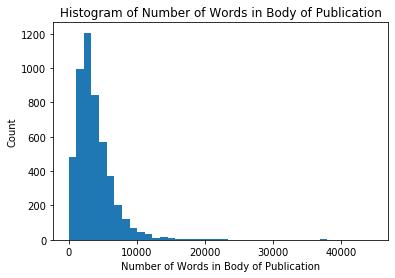

In [157]:
data = add_body['body_len']
bins = 40

plt.ylabel("Count")
plt.xlabel("Number of Words in Body of Publication")
plt.title("Histogram of Number of Words in Body of Publication")
plt.hist(data, bins)
plt.show()

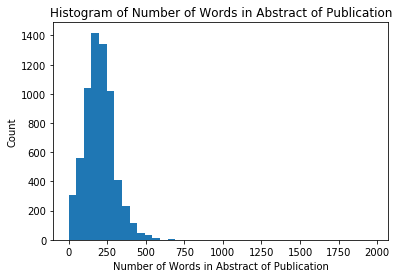

In [159]:
data = add_body['abstract_len']
bins = 40

plt.ylabel("Count")
plt.xlabel("Number of Words in Abstract of Publication")
plt.title("Histogram of Number of Words in Abstract of Publication")
plt.hist(data, bins)
plt.show()

### Use WordCloud library to examine most popular words in the first text 

In [162]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

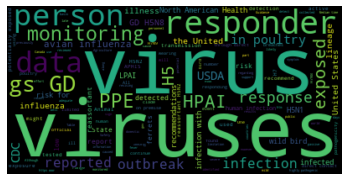

In [165]:
# https://www.datacamp.com/community/tutorials/wordcloud-python

# Start with one review:
text = add_body['body_text'][0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

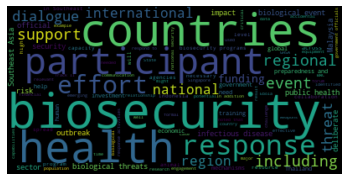

In [166]:
# Start with one review:
text = add_body['body_text'][1]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

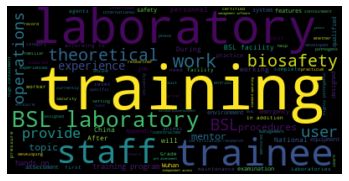

In [167]:
# Start with one review:
text = add_body['body_text'][2]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

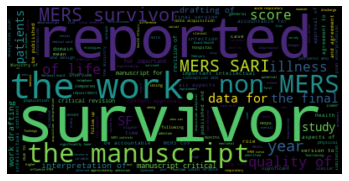

In [168]:
# Start with one review:
text = add_body['body_text'][100]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are some different themes among the different bodies of the papers

In [ ]:
# combine all reviews into one dataframe
text = " ".join(str(w) for w in add_body['body_text'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()